In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime, timedelta


In [26]:
# Load the dataset
df = pd.read_csv("10_Years_10_Companies.csv")
df.dropna(inplace=True)

# Define all required features
features = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
    'Daily_Return', 'Log_Return', 'MA10', 'MA20', 'MA50',
    'EMA10', 'EMA20', 'Volatility', 'RSI',
    'MACD', 'Signal_Line', 'BB_Middle', 'BB_Upper', 'BB_Lower'
]

# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_data = scaler_X.fit_transform(df[features])  # Dataset is scaled here
scaled_target = scaler_y.fit_transform(df[['Close']])  # Target variable is scaled here

# Create sequences for the model
time_step = 60
X, y = [], []
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i])
    y.append(scaled_target[i])  # Close price

X, y = np.array(X), np.array(y)
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

model = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(time_step, len(features))),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

model.compile(optimizer='adam', loss='huber', metrics=['mse', 'mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.0512 - mae: 0.0323 - mse: 0.0042 - val_loss: 9.5738e-04 - val_mae: 0.0091 - val_mse: 9.8578e-05
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.0512 - mae: 0.0323 - mse: 0.0042 - val_loss: 9.5738e-04 - val_mae: 0.0091 - val_mse: 9.8578e-05
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - loss: 0.0012 - mae: 0.0176 - mse: 0.0011 - val_loss: 3.3452e-04 - val_mae: 0.0045 - val_mse: 2.7969e-05
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - loss: 0.0012 - mae: 0.0176 - mse: 0.0011 - val_loss: 3.3452e-04 - val_mae: 0.0045 - val_mse: 2.7969e-05
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - loss: 8.5419e-04 - mae: 0.0161 - mse: 0.0011 - val_loss: 2.6213e-04 - val_mae: 0.0072 - val_mse: 6.6208e-05
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - loss: 8.5419e-04 - mae: 0.0161 - mse: 0.0011 - val_loss: 2.6213e-04 - val_mae: 0.0072 - val_mse: 6.6208e-05
Epoch 4/100
689/689 ━━━━━━

In [34]:
def predict_realtime(model, scaler, company_symbol, features, time_step=60):
    """
    Fetches last 100 days of stock data from Yahoo Finance
    and predicts the next-day closing price.
    """
    try:
        # Fetch last 100 days
        df_live = yf.download(company_symbol, period='6mo', interval='1d')
        df_live.dropna(inplace=True)
        
        # Ensure columns exist
        for f in features:
            if f not in df_live.columns:
                df_live[f] = 0.0  # or compute feature if needed

        # Scale and prepare sequence
        scaled_live = scaler.transform(df_live[features])
        X_live = [scaled_live[i - time_step:i] for i in range(time_step, len(scaled_live))]
        X_live = np.array(X_live)

        # Predict
        predicted_scaled = model.predict(X_live)
        temp = np.zeros((len(predicted_scaled), len(features)))
        temp[:, 3] = predicted_scaled[:, 0]
        predicted_close = scaler.inverse_transform(temp)[:, 3]

        print(f"✅ {company_symbol}: Predicted next close = {predicted_close[-1]:.2f}")
        return predicted_close[-1]

    except Exception as e:
        print(f"⚠️ Error analyzing {company_symbol}: {e}")


In [29]:
companies = [
    'TCS.NS', 'RELIANCE.NS', 'INFY.NS', 'HDFCBANK.NS',
    'ICICIBANK.NS', 'SBIN.NS', 'ITC.NS', 'LT.NS',
    'AXISBANK.NS', 'BHARTIARTL.NS'
]

for company in companies:
    predict_realtime(model, scaler, company, features, time_step)


C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')
[*********************100%***********************]  1 of 1 completed
c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(

c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
✅ TCS.NS: Predicted next close = 896.33
✅ TCS.NS: Predicted next close = 896.33


C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')
[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ RELIANCE.NS: Predicted next close = 351.97


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ INFY.NS: Predicted next close = 377.79


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ HDFCBANK.NS: Predicted next close = 254.54


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ ICICIBANK.NS: Predicted next close = 354.66


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ SBIN.NS: Predicted next close = 238.05


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ ITC.NS: Predicted next close = 207.11


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ LT.NS: Predicted next close = 1104.21


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\NARASAREDDY\AppData\Local\Temp\ipykernel_21720\755781145.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_live = yf.download(company_symbol, period='6mo', interval='1d')


✅ AXISBANK.NS: Predicted next close = 281.65


[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ BHARTIARTL.NS: Predicted next close = 546.56
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ BHARTIARTL.NS: Predicted next close = 546.56



c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Training XGBoost model...
[0]	validation_0-rmse:0.09719
[0]	validation_0-rmse:0.09719
[1]	validation_0-rmse:0.09234
[1]	validation_0-rmse:0.09234
[2]	validation_0-rmse:0.08774
[2]	validation_0-rmse:0.08774
[3]	validation_0-rmse:0.08340
[3]	validation_0-rmse:0.08340
[4]	validation_0-rmse:0.07927
[4]	validation_0-rmse:0.07927
[5]	validation_0-rmse:0.07532
[5]	validation_0-rmse:0.07532
[6]	validation_0-rmse:0.07156
[6]	validation_0-rmse:0.07156
[7]	validation_0-rmse:0.06800
[7]	validation_0-rmse:0.06800
[8]	validation_0-rmse:0.06464
[8]	validation_0-rmse:0.06464
[9]	validation_0-rmse:0.06145
[9]	validation_0-rmse:0.06145
[10]	validation_0-rmse:0.05838
[10]	validation_0-rmse:0.05838
[11]	validation_0-rmse:0.05547
[11]	validation_0-rmse:0.05547
[12]	validation_0-rmse:0.05271
[12]	validation_0-rmse:0.05271
[13]	validation_0-rmse:0.05009
[13]	validation_0-rmse:0.05009
[14]	validation_0-rmse:0.04761
[14]	validation_0-rmse:0.04761
[15]	validation_0-rmse:0.04524
[15]	validation_0-rmse:0.04524
[1

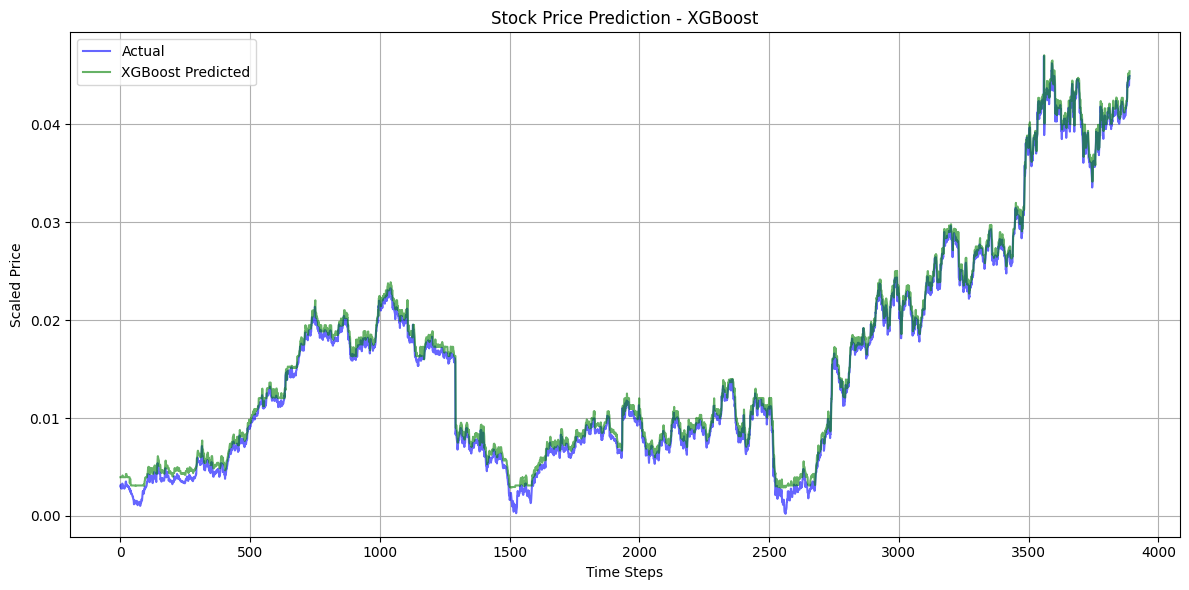

NameError: name 'mean_squared_error' is not defined

In [30]:
# Import and train XGBoost properly
import xgboost as xgb
from xgboost import XGBRegressor

# Reshape data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)  # Flatten the sequences
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Initialize XGBoost with corrected parameters
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train with proper error handling
print("Training XGBoost model...")
xgb_model.fit(
    X_train_xgb, 
    y_train,
    eval_set=[(X_test_xgb, y_test)],
    verbose=True
)

# Predict
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue', alpha=0.6)
plt.plot(y_pred_xgb, label='XGBoost Predicted', color='green', alpha=0.6)
plt.title('Stock Price Prediction - XGBoost')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
mse = mean_squared_error(y_test, y_pred_xgb)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")


In [62]:
# Install yfinance if not already installed
!pip install yfinance

In [31]:
def get_realtime_data(ticker, period='1y'):
    """
    Fetch real-time market data and calculate indicators
    """
    stock = yf.Ticker(ticker)
    df_rt = stock.history(period=period)
    
    # Calculate indicators while preserving yfinance column names
    df_rt['Daily_Return'] = df_rt['Close'].pct_change()
    df_rt['Log_Return'] = np.log1p(df_rt['Daily_Return'])
    df_rt['MA10'] = df_rt['Close'].rolling(10).mean()
    df_rt['MA20'] = df_rt['Close'].rolling(20).mean()
    df_rt['MA50'] = df_rt['Close'].rolling(50).mean()
    df_rt['EMA10'] = df_rt['Close'].ewm(span=10, adjust=False).mean()
    df_rt['EMA20'] = df_rt['Close'].ewm(span=20, adjust=False).mean()
    df_rt['Volatility'] = df_rt['Daily_Return'].rolling(20).std()
    
    # RSI
    delta = df_rt['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_rt['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df_rt['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df_rt['Close'].ewm(span=26, adjust=False).mean()
    df_rt['MACD'] = exp1 - exp2
    df_rt['Signal_Line'] = df_rt['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df_rt['BB_Middle'] = df_rt['Close'].rolling(window=20).mean()
    std = df_rt['Close'].rolling(window=20).std()
    df_rt['BB_Upper'] = df_rt['BB_Middle'] + (std * 2)
    df_rt['BB_Lower'] = df_rt['BB_Middle'] - (std * 2)
    
    return df_rt.dropna()

In [32]:
def predict_next_day(ticker, lstm_model, xgb_model, scaler_X, scaler_y, time_step=60):
    """Predict next day's closing price using both LSTM and XGBoost models"""
    rt_data = get_realtime_data(ticker)

    # Add Adj Close column if missing
    if 'Adj Close' not in rt_data.columns:
        rt_data['Adj Close'] = rt_data['Close']

    # Features matching training data
    features = [
        'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
        'Daily_Return', 'Log_Return', 'MA10', 'MA20', 'MA50',
        'EMA10', 'EMA20', 'Volatility', 'RSI', 'MACD', 'Signal_Line',
        'BB_Middle', 'BB_Upper', 'BB_Lower'
    ]

    # Verify data
    if len(rt_data) < time_step:
        raise ValueError(f"Not enough data points. Need at least {time_step} days.")

    # Prepare features with proper DataFrame
    data = pd.DataFrame(rt_data[features].values, columns=features)
    scaled_rt_data = scaler_X.transform(data)

    # Get sequence for prediction
    last_sequence = scaled_rt_data[-time_step:]
    lstm_input = last_sequence.reshape(1, time_step, len(features))
    xgb_input = lstm_input.reshape(1, -1)

    # Make predictions with reduced verbosity
    lstm_pred = lstm_model.predict(lstm_input, verbose=0)
    lstm_price = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))

    xgb_pred = xgb_model.predict(xgb_input)
    xgb_price = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))

    current_price = rt_data['Close'].iloc[-1]

    # Calculate prediction errors
    lstm_error = abs(lstm_price[0][0] - current_price)
    xgb_error = abs(xgb_price[0][0] - current_price)

    # Print formatted results
    print(f"\n{'='*50}")
    print(f"Predictions for {ticker}")
    print(f"{'='*50}")
    print(f"Current Price:     ₹{current_price:,.2f}")
    print(f"LSTM Prediction:   ₹{lstm_price[0][0]:,.2f} (Error: ₹{lstm_error:,.2f})")
    print(f"XGBoost Prediction:₹{xgb_price[0][0]:,.2f} (Error: ₹{xgb_error:,.2f})")
    print(f"{'='*50}")

    return lstm_price[0][0], xgb_price[0][0], current_price


Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: ₹53.90)

Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: ₹53.90)

Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: ₹53.90)

Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: ₹53.90)

Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: ₹53.90)

Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: ₹53.90)

Predictions for TCS.NS
Current Price:     ₹2,983.50
LSTM Prediction:   ₹3,166.84 (Error: ₹183.34)
XGBoost Prediction:₹2,929.60 (Error: 

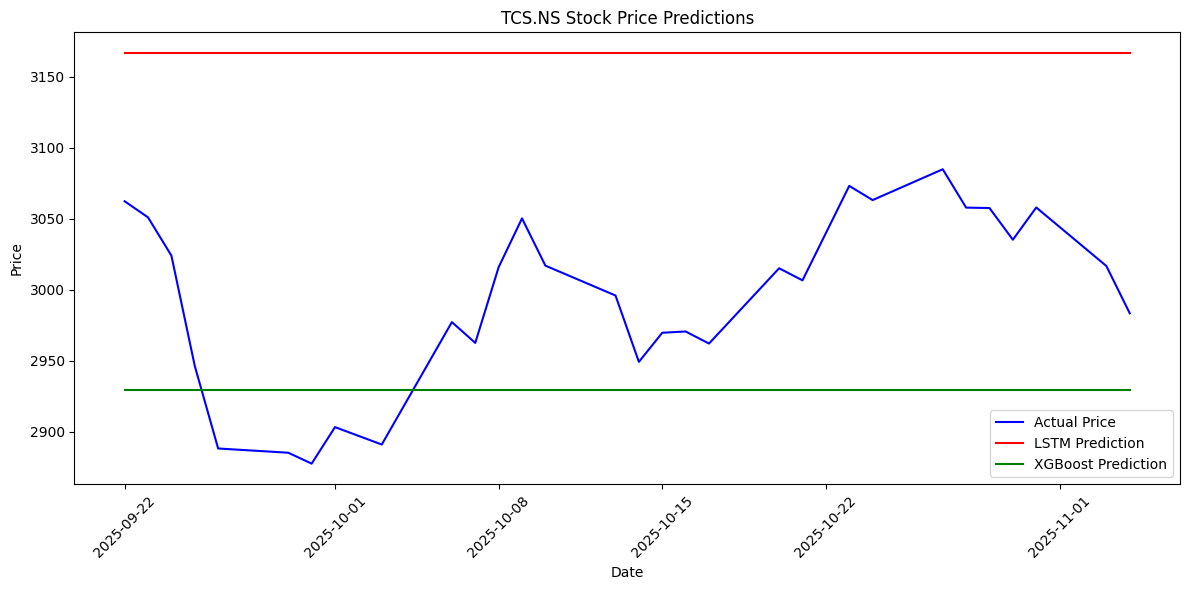


Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Prediction:₹1,487.81 (Error: ₹6.11)

Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Prediction:₹1,487.81 (Error: ₹6.11)

Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Prediction:₹1,487.81 (Error: ₹6.11)

Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Prediction:₹1,487.81 (Error: ₹6.11)

Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Prediction:₹1,487.81 (Error: ₹6.11)

Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Prediction:₹1,487.81 (Error: ₹6.11)

Predictions for RELIANCE.NS
Current Price:     ₹1,481.70
LSTM Prediction:   ₹1,519.04 (Error: ₹37.34)
XGBoost Predict

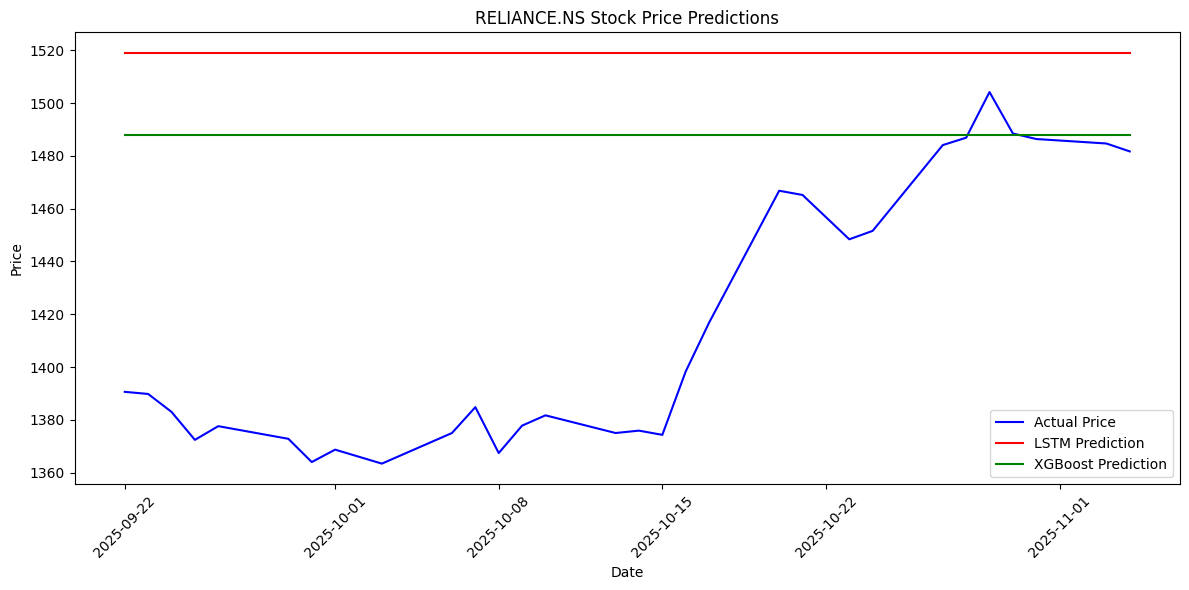


Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

Predictions for INFY.NS
Current Price:     ₹1,472.30
LSTM Prediction:   ₹1,535.88 (Error: ₹63.58)
XGBoost Prediction:₹1,476.55 (Error: ₹4.25)

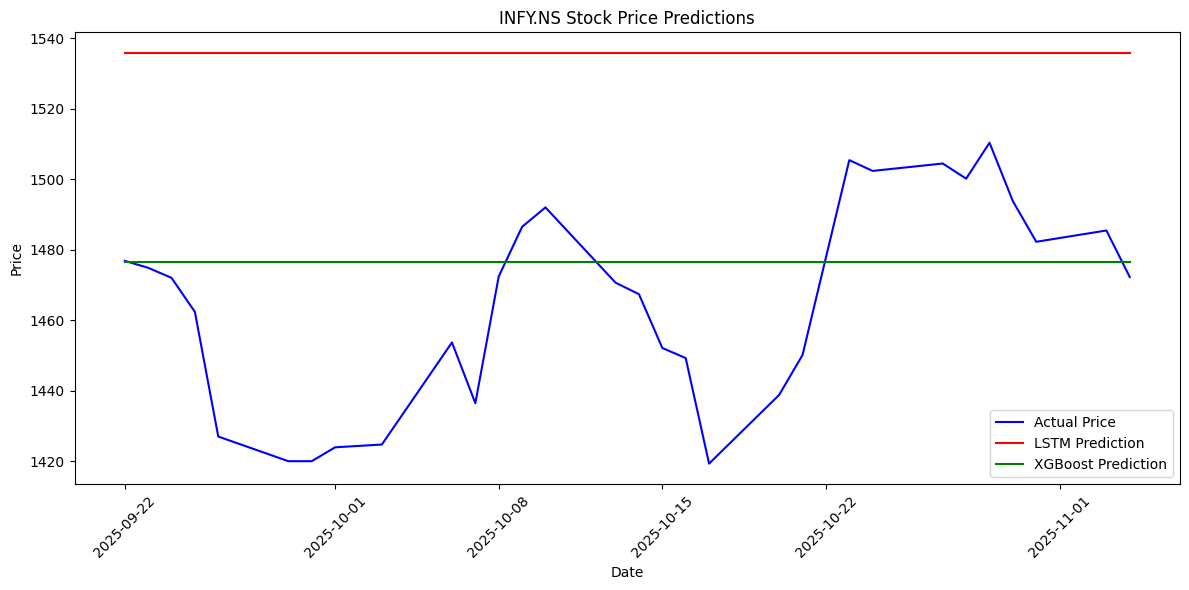

In [33]:
# Visualization of predictions vs actual prices
def plot_predictions(ticker, days_to_plot=30):
    rt_data = get_realtime_data(ticker)
    
    # Ensure we have enough data points
    if len(rt_data) < days_to_plot + time_step:
        raise ValueError(f"Not enough data points. Need at least {days_to_plot + time_step} days.")
    
    # Get the last days_to_plot days of actual prices
    actual_prices = rt_data['Close'].iloc[-days_to_plot:]
    dates = actual_prices.index
    
    lstm_predictions = []
    xgb_predictions = []
    
    # Generate predictions for each day in the plotting window
    for i in range(days_to_plot):
        # Get the time window ending at the current day
        end_idx = -(days_to_plot - i)
        if end_idx == 0:  # Handle the last day case
            data_window = rt_data.iloc[-time_step:]
        else:
            data_window = rt_data.iloc[end_idx - time_step:end_idx]
        
        # Get predictions for this window with both scalers
        lstm_pred, xgb_pred, _ = predict_next_day(ticker, lstm_model, xgb_model, scaler_X, scaler_y)
        lstm_predictions.append(lstm_pred)
        xgb_predictions.append(xgb_pred)
    
    # Convert predictions to numpy arrays
    lstm_predictions = np.array(lstm_predictions)
    xgb_predictions = np.array(xgb_predictions)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_prices, label='Actual Price', color='blue')
    plt.plot(dates, lstm_predictions, label='LSTM Prediction', color='red')
    plt.plot(dates, xgb_predictions, label='XGBoost Prediction', color='green')
    plt.title(f'{ticker} Stock Price Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Test visualization
test_tickers = ['TCS.NS', 'RELIANCE.NS', 'INFY.NS']
for ticker in test_tickers:
    try:
        plot_predictions(ticker)
    except ValueError as e:
        print(f"Error plotting {ticker}: {str(e)}")

In [18]:
def plot_predictions_analysis(ticker, days_to_plot=30):
    """Enhanced visualization with prediction analysis"""
    rt_data = get_realtime_data(ticker)
    
    if len(rt_data) < days_to_plot + time_step:
        raise ValueError(f"Not enough data points. Need at least {days_to_plot + time_step} days.")
    
    # Get data and make predictions
    actual_prices = rt_data['Close'].iloc[-days_to_plot:]
    dates = actual_prices.index
    
    lstm_predictions = []
    xgb_predictions = []
    
    # Generate predictions
    for i in range(days_to_plot):
        # Get the time window ending at the current day
        end_idx = -(days_to_plot - i)
        if end_idx == 0:  # Handle the last day case
            data_window = rt_data.iloc[-time_step:]
        else:
            data_window = rt_data.iloc[end_idx - time_step:end_idx]
        
        # Get predictions for this window with both scalers
        lstm_pred, xgb_pred, _ = predict_next_day(ticker, lstm_model, xgb_model, scaler_X, scaler_y)
        lstm_predictions.append(lstm_pred)
        xgb_predictions.append(xgb_pred)
    
    # Convert predictions to numpy arrays
    lstm_predictions = np.array(lstm_predictions)
    xgb_predictions = np.array(xgb_predictions)
    
    # Create subplots for analysis
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Price Predictions
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(dates, actual_prices, label='Actual', color='blue')
    ax1.plot(dates, lstm_predictions, label='LSTM', color='red', alpha=0.7)
    ax1.plot(dates, xgb_predictions, label='XGBoost', color='green', alpha=0.7)
    ax1.set_title('Price Predictions')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Prediction Errors
    ax2 = plt.subplot(2, 2, 2)
    lstm_errors = np.abs(actual_prices - lstm_predictions)
    xgb_errors = np.abs(actual_prices - xgb_predictions)
    ax2.plot(dates, lstm_errors, label='LSTM Error', color='red', alpha=0.7)
    ax2.plot(dates, xgb_errors, label='XGBoost Error', color='green', alpha=0.7)
    ax2.set_title('Prediction Errors')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Absolute Error')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Error Distribution
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(lstm_errors, bins=20, alpha=0.5, label='LSTM', color='red')
    ax3.hist(xgb_errors, bins=20, alpha=0.5, label='XGBoost', color='green')
    ax3.set_title('Error Distribution')
    ax3.set_xlabel('Prediction Error')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    
    # 4. Model Comparison Metrics
    ax4 = plt.subplot(2, 2, 4)
    metrics = {
        'LSTM': {
            'RMSE': np.sqrt(mean_squared_error(actual_prices, lstm_predictions)),
            'MAE': np.mean(np.abs(actual_prices - lstm_predictions)),
            'Mean Error': np.mean(lstm_errors)
        },
        'XGBoost': {
            'RMSE': np.sqrt(mean_squared_error(actual_prices, xgb_predictions)),
            'MAE': np.mean(np.abs(actual_prices - xgb_predictions)),
            'Mean Error': np.mean(xgb_errors)
        }
    }
    
    # Bar plot for metrics
    x = np.arange(len(metrics['LSTM']))
    width = 0.35
    ax4.bar(x - width/2, metrics['LSTM'].values(), width, label='LSTM', color='red', alpha=0.7)
    ax4.bar(x + width/2, metrics['XGBoost'].values(), width, label='XGBoost', color='green', alpha=0.7)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics['LSTM'].keys())
    ax4.set_title('Model Performance Metrics')
    ax4.legend()
    
    plt.suptitle(f'Stock Price Prediction Analysis - {ticker}', size=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\nDetailed Metrics for {ticker}:")
    print("LSTM Metrics:")
    for metric, value in metrics['LSTM'].items():
        print(f"{metric}: {value:.2f}")
    print("\nXGBoost Metrics:")
    for metric, value in metrics['XGBoost'].items():
        print(f"{metric}: {value:.2f}")

# Test enhanced visualization
test_tickers = ['TCS.NS', 'RELIANCE.NS', 'INFY.NS']
for ticker in test_tickers:
    try:
        plot_predictions_analysis(ticker)
    except Exception as e:
        print(f"Error analyzing {ticker}: {str(e)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Error analyzing TCS.NS: Feature shape mismatch, expected: 1, got 1200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Error analyzing RELIANCE.NS: Feature shape mismatch, expected: 1, got 1200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Error analyzing INFY.NS: Feature shape mismatch, expected: 1, got 1200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Error analyzing INFY.NS: Feature shape mismatch, expected: 1, got 1200


c:\Users\NARASAREDDY\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
def compare_predictions(companies, days=5):
    """Compare predicted vs actual closing prices for multiple companies"""
    comparison_data = []
    
    for company in companies:
        try:
            # Get historical data
            df = yf.download(company, period=f'{days+2}d', interval='1d')
            actual_prices = df['Close'].values
            
            # Get yesterday's data for prediction
            yesterday_data = df.iloc[:-1]
            
            # Prepare features
            for f in features:
                if f not in yesterday_data.columns:
                    yesterday_data[f] = 0.0
            
            # Scale and predict
            scaled_data = scaler_X.transform(yesterday_data[features])
            last_sequence = scaled_data[-time_step:]
            X_pred = last_sequence.reshape(1, time_step, len(features))
            
            # Get prediction
            pred = model.predict(X_pred)
            pred = scaler_y.inverse_transform(pred)[0][0]
            
            comparison_data.append({
                'Company': company,
                'Predicted': pred,
                'Actual': actual_prices[-1],
                'Error': abs(pred - actual_prices[-1])
            })
            
        except Exception as e:
            print(f"Error processing {company}: {str(e)}")
    
    # Create visualization
    results_df = pd.DataFrame(comparison_data)
    
    plt.figure(figsize=(15, 8))
    
    # Bar plot comparing predicted vs actual
    x = np.arange(len(results_df))
    width = 0.35
    
    plt.bar(x - width/2, results_df['Predicted'], width, label='Predicted', alpha=0.7, color='blue')
    plt.bar(x + width/2, results_df['Actual'], width, label='Actual', alpha=0.7, color='green')
    
    plt.xlabel('Companies')
    plt.ylabel('Closing Price')
    plt.title('Predicted vs Actual Closing Prices')
    plt.xticks(x, results_df['Company'], rotation=45)
    plt.legend()
    
    # Add error values on top
    for i, row in results_df.iterrows():
        plt.text(i, max(row['Predicted'], row['Actual']), 
                f"Error: {row['Error']:.2f}", 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print("\nPrediction Comparison:")
    print(results_df.round(2))
    
    # Print average error
    print(f"\nMean Absolute Error: {results_df['Error'].mean():.2f}")

# Test with key companies
companies = [
    'TCS.NS', 'RELIANCE.NS', 'INFY.NS', 'HDFCBANK.NS',
    'ICICIBANK.NS', 'SBIN.NS'
]

compare_predictions(companies)


In [ ]:
def get_realtime_data(ticker, period='1y'):
    """
    Fetch real-time market data and calculate indicators
    """
    stock = yf.Ticker(ticker)
    df_rt = stock.history(period=period)
    
    # Calculate indicators while preserving yfinance column names
    df_rt['Daily_Return'] = df_rt['Close'].pct_change()
    df_rt['Log_Return'] = np.log1p(df_rt['Daily_Return'])
    df_rt['MA10'] = df_rt['Close'].rolling(10).mean()
    df_rt['MA20'] = df_rt['Close'].rolling(20).mean()
    df_rt['MA50'] = df_rt['Close'].rolling(50).mean()
    df_rt['EMA10'] = df_rt['Close'].ewm(span=10, adjust=False).mean()
    df_rt['EMA20'] = df_rt['Close'].ewm(span=20, adjust=False).mean()
    df_rt['Volatility'] = df_rt['Daily_Return'].rolling(20).std()
    
    # RSI
    delta = df_rt['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_rt['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df_rt['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df_rt['Close'].ewm(span=26, adjust=False).mean()
    df_rt['MACD'] = exp1 - exp2
    df_rt['Signal_Line'] = df_rt['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df_rt['BB_Middle'] = df_rt['Close'].rolling(window=20).mean()
    std = df_rt['Close'].rolling(window=20).std()
    df_rt['BB_Upper'] = df_rt['BB_Middle'] + (std * 2)
    df_rt['BB_Lower'] = df_rt['BB_Middle'] - (std * 2)
    
    return df_rt.dropna()


In [ ]:
def predict_next_days(ticker, lstm_model, xgb_model, scaler_X, scaler_y, num_days=5, time_step=60):
    """Predict closing prices for multiple days ahead"""
    rt_data = get_realtime_data(ticker)
    
    # Add Adj Close column if missing
    if 'Adj Close' not in rt_data.columns:
        rt_data['Adj Close'] = rt_data['Close']
    
    # Features matching training data
    features = [
        'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
        'Daily_Return', 'Log_Return', 'MA10', 'MA20', 'MA50',
        'EMA10', 'EMA20', 'Volatility', 'RSI', 'MACD', 'Signal_Line',
        'BB_Middle', 'BB_Upper', 'BB_Lower'
    ]
    
    # Verify data
    if len(rt_data) < time_step:
        raise ValueError(f"Not enough data points. Need at least {time_step} days.")
    
    # Prepare features with proper DataFrame
    data = pd.DataFrame(rt_data[features].values, columns=features)
    scaled_rt_data = scaler_X.transform(data)
    
    # Lists to store predictions
    lstm_predictions = []
    xgb_predictions = []
    dates = []
    
    # Current sequence for prediction
    current_sequence = scaled_rt_data[-time_step:]
    
    # Predict for num_days
    for i in range(num_days):
        # Prepare input
        lstm_input = current_sequence.reshape(1, time_step, len(features))
        xgb_input = lstm_input.reshape(1, -1)
        
        # Make predictions
        lstm_pred = lstm_model.predict(lstm_input, verbose=0)
        lstm_price = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))[0][0]
        
        xgb_pred = xgb_model.predict(xgb_input)
        xgb_price = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))[0][0]
        
        # Store predictions
        lstm_predictions.append(lstm_price)
        xgb_predictions.append(xgb_price)
        
        # Calculate next date
        next_date = rt_data.index[-1] + pd.Timedelta(days=i+1)
        dates.append(next_date)
        
        # Update sequence for next prediction by shifting and adding new prediction
        # Create a dummy row with the predicted values
        new_row = np.zeros(len(features))
        new_row[3] = lstm_pred[0]  # Use LSTM prediction for next sequence
        new_row = scaler_X.transform(new_row.reshape(1, -1))
        
        # Update sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_row
    
    # Visualize predictions
    plt.figure(figsize=(12, 6))
    plt.plot(dates, lstm_predictions, 'r-o', label='LSTM Predictions', alpha=0.7)
    plt.plot(dates, xgb_predictions, 'g-o', label='XGBoost Predictions', alpha=0.7)
    plt.title(f'{ticker} - Next {num_days} Days Price Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print tabulated predictions
    print(f"\n{'='*60}")
    print(f"Price Predictions for {ticker} - Next {num_days} Days")
    print(f"{'='*60}")
    print(f"{'Date':<12} {'LSTM Price':>15} {'XGBoost Price':>15} {'Avg Price':>15}")
    print(f"{'-'*60}")
    
    for date, lstm_p, xgb_p in zip(dates, lstm_predictions, xgb_predictions):
        avg_price = (lstm_p + xgb_p) / 2
        print(f"{date.strftime('%Y-%m-%d'):<12} ₹{lstm_p:>14,.2f} ₹{xgb_p:>14,.2f} ₹{avg_price:>14,.2f}")
    
    print(f"{'='*60}")
    
    return dates, lstm_predictions, xgb_predictions

# Test the multi-day prediction
test_tickers = ['TCS.NS', 'RELIANCE.NS', 'INFY.NS']

# Get number of days from user
num_days = int(input("Enter number of days to predict (1-30): "))
num_days = max(1, min(30, num_days))  # Limit between 1 and 30 days

for ticker in test_tickers:
    try:
        predict_next_days(ticker, lstm_model, xgb_model, scaler_X, scaler_y, num_days=num_days)
    except Exception as e:
        print(f"Error predicting {ticker}: {str(e)}")


In [6]:
def run_stock_analysis():
    """Interactive function to analyze stocks"""
    print("\n=== Stock Price Prediction System ===\n")
    
    # Get stock symbol
    print("Available Markets:")
    print("1. Indian Stocks (add .NS)")
    print("2. US Stocks")
    ticker = input("\nEnter stock symbol (e.g., TCS.NS or AAPL): ").upper()
    
    # Get prediction type
    print("\nSelect Analysis Type:")
    print("1. Quick Prediction (next day)")
    print("2. Multi-day Forecast")
    print("3. Detailed Analysis")
    print("4. Compare with Other Stocks")
    
    choice = input("\nEnter your choice (1-4): ")
    
    try:
        if choice == '1':
            predict_next_day(ticker, lstm_model, xgb_model, scaler_X, scaler_y)
            
        elif choice == '2':
            days = int(input("\nEnter number of days to predict (1-30): "))
            days = max(1, min(30, days))
            predict_next_days(ticker, lstm_model, xgb_model, scaler_X, scaler_y, num_days=days)
            
        elif choice == '3':
            plot_predictions_analysis(ticker)
            
        elif choice == '4':
            print("\nEnter additional stock symbols (comma-separated):")
            additional_tickers = input("e.g., RELIANCE.NS, INFY.NS: ").upper()
            compare_stocks = [ticker] + [t.strip() for t in additional_tickers.split(',')]
            compare_predictions(compare_stocks)
            
        else:
            print("Invalid choice! Please select 1-4")
            
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("\nTips:")
        print("- For Indian stocks, add .NS (e.g., TCS.NS)")
        print("- Ensure you have internet connection")
        print("- Check if the stock symbol is correct")

# Run the analysis
run_stock_analysis()


=== Stock Price Prediction System ===

Available Markets:
1. Indian Stocks (add .NS)
2. US Stocks

Select Analysis Type:
1. Quick Prediction (next day)
2. Multi-day Forecast
3. Detailed Analysis
4. Compare with Other Stocks

Error: name 'plot_predictions_analysis' is not defined

Tips:
- For Indian stocks, add .NS (e.g., TCS.NS)
- Ensure you have internet connection
- Check if the stock symbol is correct


In [11]:
# Import matplotlib.pyplot for visualization
import matplotlib.pyplot as plt

In [ ]:
# Import mean_squared_error for calculating metrics
from sklearn.metrics import mean_squared_error

In [16]:
# Assign the trained LSTM model to lstm_model
lstm_model = model

In [35]:
# Predict today's TCS stock price
try:
    lstm_pred, xgb_pred, current_price = predict_next_day('TCS.NS', lstm_model, xgb_model, scaler_X, scaler_y)
    avg_price = (lstm_pred + xgb_pred) / 2
    print('\n---- TCS.NS Prediction Summary ----')
    print(f"LSTM predicted next close:    ₹{lstm_pred:,.2f}")
    print(f"XGBoost predicted next close: ₹{xgb_pred:,.2f}")
    print(f"Average predicted close:      ₹{avg_price:,.2f}")
    print(f"Current latest close price:   ₹{current_price:,.2f}")
except Exception as e:
    print(f"Prediction failed: {e}\nMake sure you are connected to the internet and that all prior cells have been executed.")


Predictions for TCS.NS
Current Price:     ₹2,988.00
LSTM Prediction:   ₹3,166.85 (Error: ₹178.85)
XGBoost Prediction:₹2,929.60 (Error: ₹58.40)

---- TCS.NS Prediction Summary ----
LSTM predicted next close:    ₹3,166.85
XGBoost predicted next close: ₹2,929.60
Average predicted close:      ₹3,048.23
Current latest close price:   ₹2,988.00


In [36]:
# Save the trained models and scalers as pickle files for frontend integration
import pickle

# Save LSTM model
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)

# Save XGBoost model
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save scalers
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print("Models and scalers have been saved as pickle files.")

Models and scalers have been saved as pickle files.
